# A Menagerie of Lenses

Here we have a quick visual demo of every type of lens in caustic. This is a good way to pick out what you need and quickly copy paste. For all of these lenses we have placed a Sersic source with the same parameters as the background, that way you can visualize the differences between them.

In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch.nn.functional import avg_pool2d
import matplotlib.pyplot as plt
from ipywidgets import interact
from astropy.io import fits
import numpy as np
from time import process_time as time

import caustic

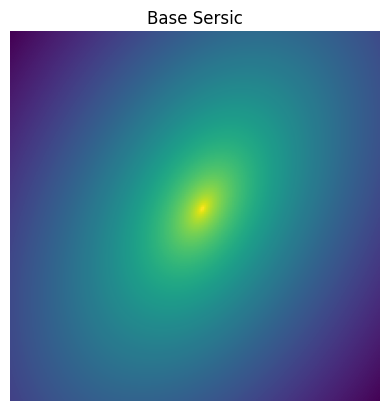

In [2]:
cosmology = caustic.FlatLambdaCDM(name = "cosmo")
cosmology.to(dtype=torch.float32)
z_s = torch.tensor(1.)
base_sersic = caustic.sources.Sersic(
    name = "sersic",
    x0 = torch.tensor(0.1),
    y0 = torch.tensor(0.1),
    q = torch.tensor(0.6),
    phi = torch.tensor(np.pi/3),
    n = torch.tensor(2.),
    Re = torch.tensor(1.),
    Ie = torch.tensor(1.),
)
n_pix = 100
res = 0.05
upsample_factor = 2
fov = res * n_pix
thx, thy = caustic.get_meshgrid(res/upsample_factor, upsample_factor*n_pix, upsample_factor*n_pix, dtype=torch.float32)
z_l = torch.tensor(0.5, dtype=torch.float32)

class Zoo_Sim(caustic.Simulator):
    def __init__(
        self,
        lens,
        name: str = "sim",
    ):
        super().__init__(name) # need this so `Parametrized` can do its magic
        
        # These are the lens and source objects to keep track of
        self.lens = lens
        self.src = base_sersic

    def forward(self, params):# define the forward model
        # Note this is very similar to before, except the packed up `x` is all the raytrace function needs to work
        bx, by = self.lens.raytrace(thx, thy, z_s, params)
        mu_fine = self.src.brightness(bx, by, params)
        
        # We return the sampled brightness at each pixel location
        return avg_pool2d(mu_fine.squeeze()[None, None], upsample_factor)[0, 0]
    
plt.imshow(np.log10(base_sersic.brightness(thx,thy).numpy()), origin = "lower")
plt.gca().axis("off")
plt.title("Base Sersic")
plt.show()

## Point (Point)

The simplest lens, an infinitely small point of mass (did someone say black holes?).

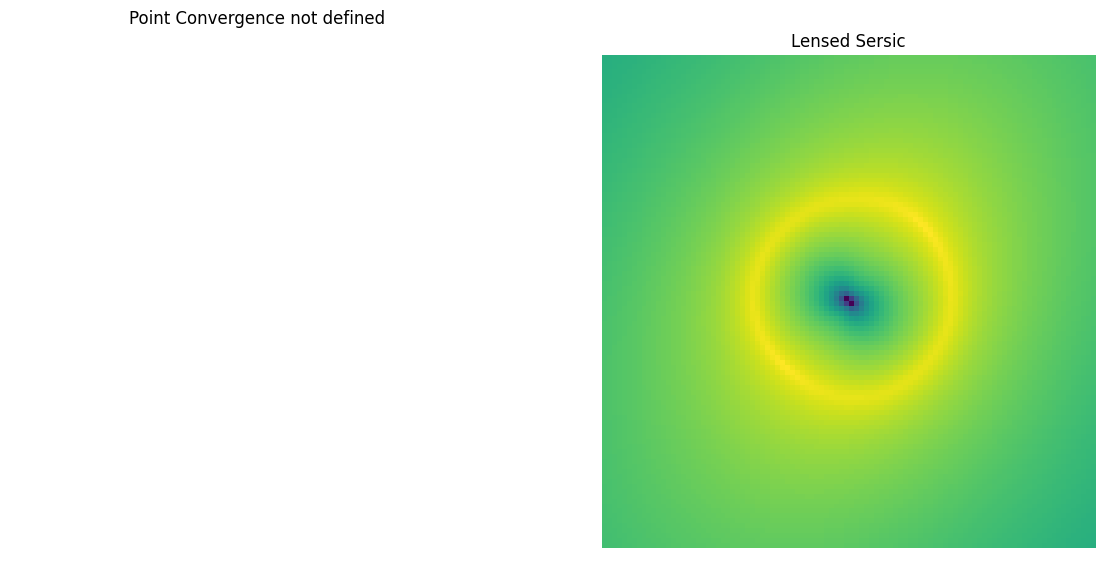

In [3]:
lens = caustic.lenses.Point(
    cosmology = cosmology,
    name = "point",
    x0 = torch.tensor(0.),
    y0 = torch.tensor(0.),
    th_ein = torch.tensor(1.),
)
sim = Zoo_Sim(lens)
fig, axarr = plt.subplots(1,2, figsize = (14,7)) 
#convergence = avg_pool2d(lens.convergence(thx, thy, z_s, z_l).squeeze()[None, None], upsample_factor).squeeze()
#axarr[0].imshow(np.log10(convergence.numpy()), origin = "lower")
axarr[0].axis("off")
axarr[0].set_title("Point Convergence not defined")
axarr[1].imshow(np.log10(sim([z_l]).numpy()), origin = "lower")
axarr[1].axis("off")
axarr[1].set_title("Lensed Sersic")
plt.show()

## Singular Isothermal Sphere (SIS)

An SIS is a mass distribution represented by a constant temperature velocity dispersion of masses. Alternatively, a constant temperature gas in a spherical gravitational potential.

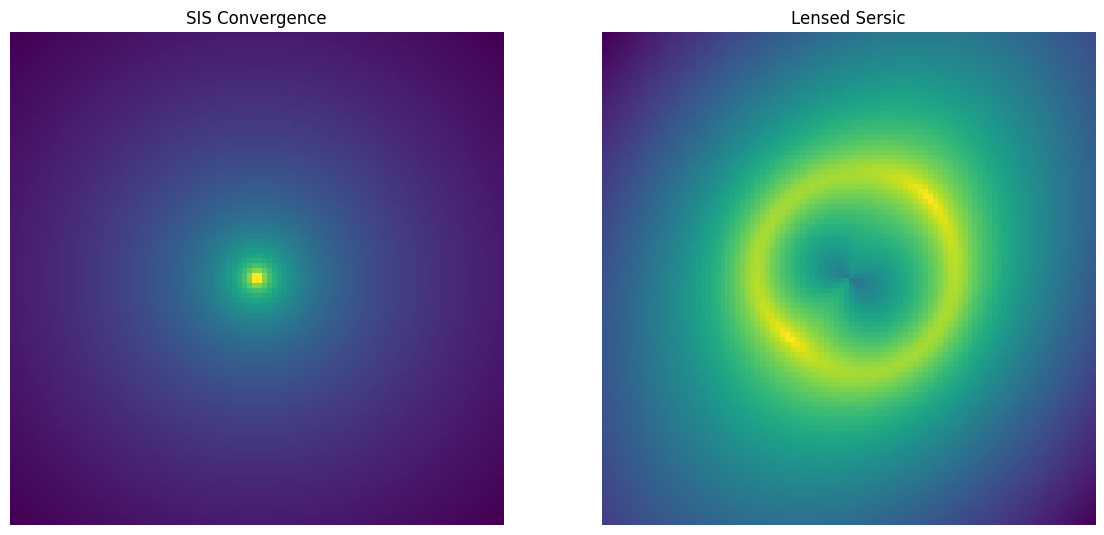

In [4]:
lens = caustic.lenses.SIS(
    cosmology = cosmology,
    name = "sis",
    x0 = torch.tensor(0.),
    y0 = torch.tensor(0.),
    th_ein = torch.tensor(1.),
)
sim = Zoo_Sim(lens)
fig, axarr = plt.subplots(1,2, figsize = (14,7)) 
convergence = avg_pool2d(lens.convergence(thx, thy, z_s, z_l).squeeze()[None, None], upsample_factor).squeeze()
axarr[0].imshow(np.log10(convergence.numpy()), origin = "lower")
axarr[0].axis("off")
axarr[0].set_title("SIS Convergence")
axarr[1].imshow(np.log10(sim([z_l]).numpy()), origin = "lower")
axarr[1].axis("off")
axarr[1].set_title("Lensed Sersic")
plt.show()

## Singular Isothermal Ellipsoid (SIE)

The SIE is just like the SIS except it has been compressed along one axis.

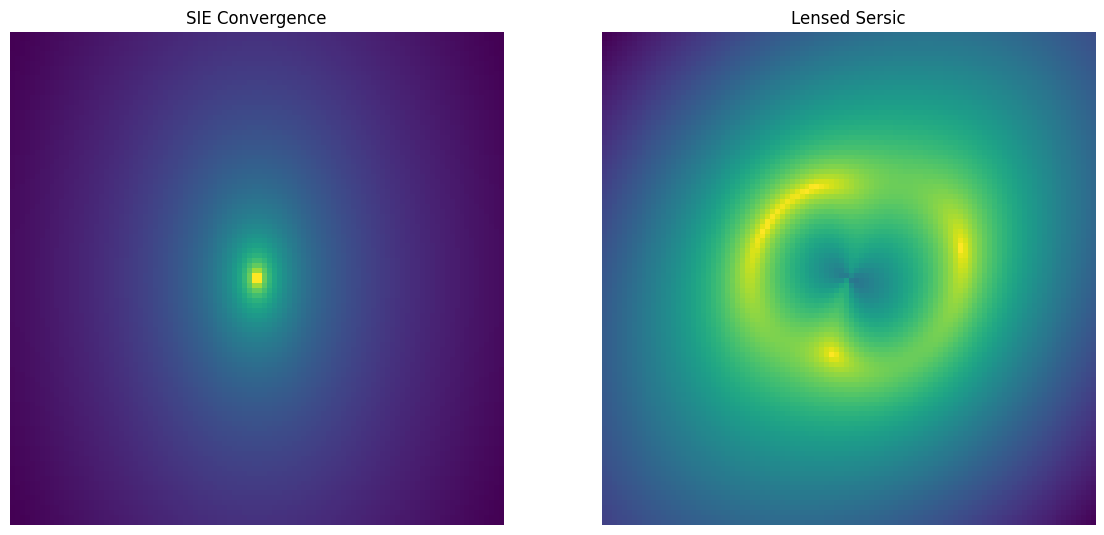

In [5]:
lens = caustic.lenses.SIE(
    cosmology = cosmology,
    name = "sie",
    x0 = torch.tensor(0.),
    y0 = torch.tensor(0.),
    q = torch.tensor(0.6),
    phi = torch.tensor(np.pi/2),
    b = torch.tensor(1.),
)
sim = Zoo_Sim(lens)
fig, axarr = plt.subplots(1,2, figsize = (14,7)) 
convergence = avg_pool2d(lens.convergence(thx, thy, z_s, z_l).squeeze()[None, None], upsample_factor).squeeze()
axarr[0].imshow(np.log10(convergence.numpy()), origin = "lower")
axarr[0].axis("off")
axarr[0].set_title("SIE Convergence")
axarr[1].imshow(np.log10(sim([z_l]).numpy()), origin = "lower")
axarr[1].axis("off")
axarr[1].set_title("Lensed Sersic")
plt.show()

## Elliptical Power Law (EPL)

This is a power law mass distribution with an elliptical isodensity contour.

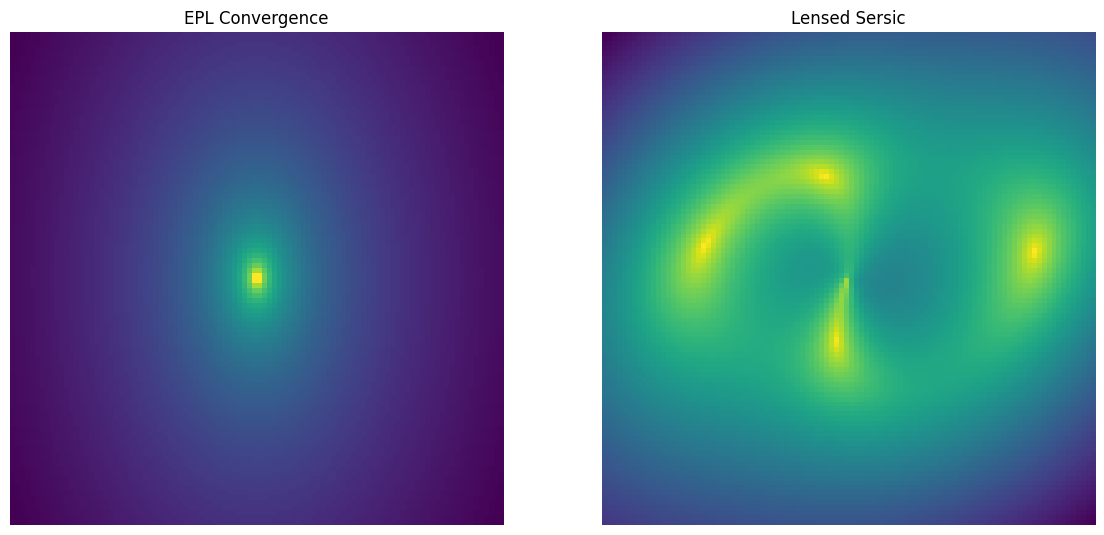

In [6]:
lens = caustic.lenses.EPL(
    cosmology = cosmology,
    name = "epl",
    x0 = torch.tensor(0.),
    y0 = torch.tensor(0.),
    q = torch.tensor(0.6),
    phi = torch.tensor(np.pi/2),
    b = torch.tensor(1.),
    t = torch.tensor(0.5),
)
sim = Zoo_Sim(lens)
fig, axarr = plt.subplots(1,2, figsize = (14,7)) 
convergence = avg_pool2d(lens.convergence(thx, thy, z_s, z_l).squeeze()[None, None], upsample_factor).squeeze()
axarr[0].imshow(np.log10(convergence.numpy()), origin = "lower")
axarr[0].axis("off")
axarr[0].set_title("EPL Convergence")
axarr[1].imshow(np.log10(sim([z_l]).numpy()), origin = "lower")
axarr[1].axis("off")
axarr[1].set_title("Lensed Sersic")
plt.show()

## Navarro Frenk White profile (NFW)

The NFW profile is a classic mass profile that approximates the mass distribution of halos in large dark matter simulations.

$$\rho(r) = \frac{\rho_0}{\frac{r}{r_s}\left(1 + \frac{r}{r_s}\right)^2}$$

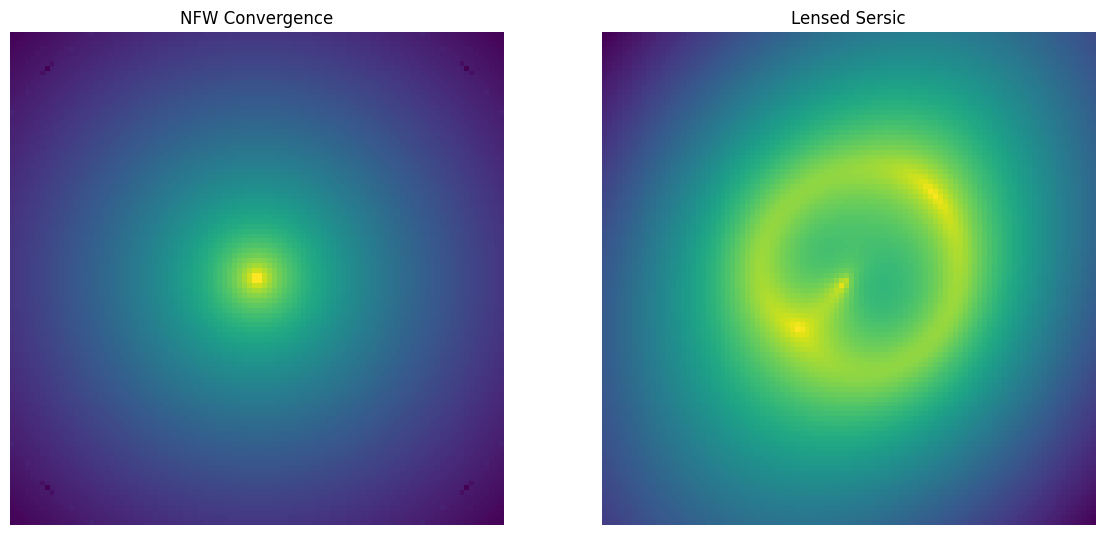

In [7]:
lens = caustic.lenses.NFW(
    cosmology = cosmology,
    name = "nfw",
    x0 = torch.tensor(0.),
    y0 = torch.tensor(0.),
    m = torch.tensor(1e13),
    c = torch.tensor(20.),
)
sim = Zoo_Sim(lens)
fig, axarr = plt.subplots(1,2, figsize = (14,7)) 
convergence = avg_pool2d(lens.convergence(thx, thy, z_s, z_l).squeeze()[None, None], upsample_factor).squeeze()
axarr[0].imshow(np.log10(convergence.numpy()), origin = "lower")
axarr[0].axis("off")
axarr[0].set_title("NFW Convergence")
axarr[1].imshow(np.log10(sim([z_l]).numpy()), origin = "lower")
axarr[1].axis("off")
axarr[1].set_title("Lensed Sersic")
plt.show()

## Truncated NFW profile (TNFW)

The TNFW profile is a slight modification to the classic NFW mass profile that approximates the mass distribution of halos in large dark matter simulations. The new density profile is defined as:

$$\rho_{\rm tnfw}(r) =  \rho_{\rm nfw}(r)\frac{\tau^2}{\tau^2 + \frac{r^2}{r_s^2}}$$

where $\tau = \frac{r_t}{r_s}$ is the ratio of the truncation radius to the scale radius. Note that the truncation happens smoothly so there are no sharp boundaries. In the TNFW profile, the mass quantity now actually corresponds the to the total mass since it is no longer divergent. This often means the mass values are larger.

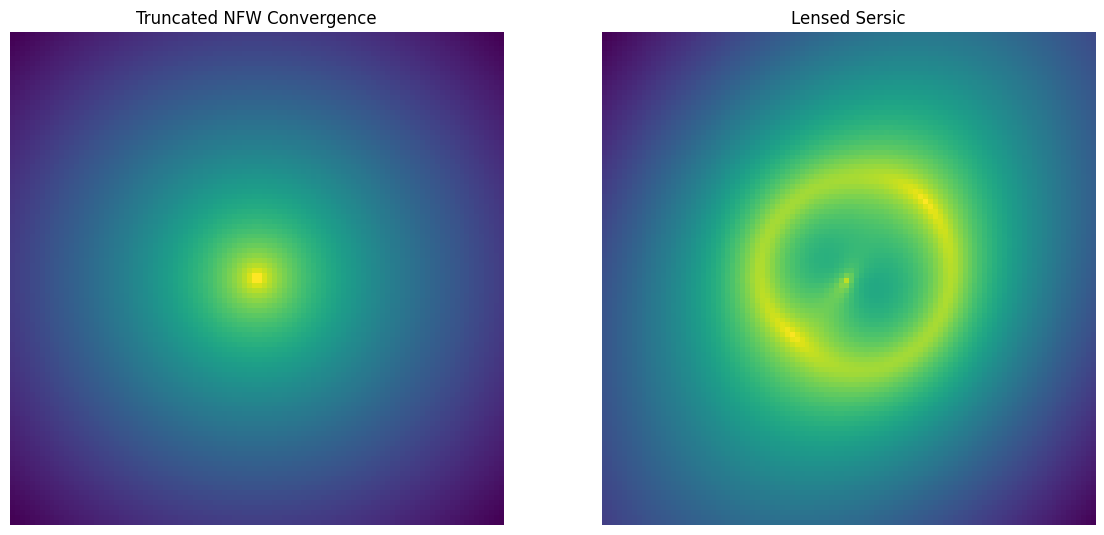

In [8]:
lens = caustic.lenses.TNFW(
    cosmology = cosmology,
    name = "tnfw",
    x0 = torch.tensor(0.),
    y0 = torch.tensor(0.),
    mass = torch.tensor(1e12),
    scale_radius = torch.tensor(1.),
    tau = torch.tensor(3.),
)
sim = Zoo_Sim(lens)
fig, axarr = plt.subplots(1,2, figsize = (14,7)) 
convergence = avg_pool2d(lens.convergence(thx, thy, z_s, z_l).squeeze()[None, None], upsample_factor).squeeze()
axarr[0].imshow(np.log10(convergence.numpy()), origin = "lower")
axarr[0].axis("off")
axarr[0].set_title("Truncated NFW Convergence")
axarr[1].imshow(np.log10(sim([z_l]).numpy()), origin = "lower")
axarr[1].axis("off")
axarr[1].set_title("Lensed Sersic")
plt.show()

## Pseudo Jaffe (PseudoJaffe)

The Pseudo Jaffe closely approximates an isothermal mass distribution except that it is easier to compute and has finite mass.

$$ \rho(r) = \frac{\rho_0}{\left(1 + \frac{r^2}{r_c^2}\right)\left(1 + \frac{r^2}{r_s^2}\right)} $$

where $\rho_0$ is the central density limit, $r_c$ is the core radius, $r_s$ is the scale radius.

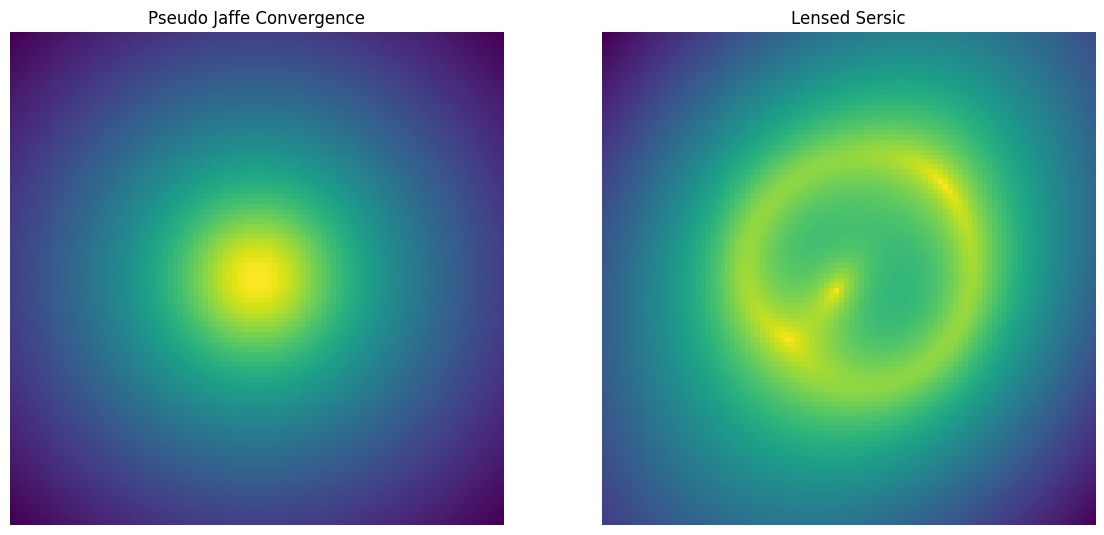

In [9]:
lens = caustic.lenses.PseudoJaffe(
    cosmology = cosmology,
    name = "pseudojaffe",
    x0 = torch.tensor(0.),
    y0 = torch.tensor(0.),
    mass = torch.tensor(1e13),
    core_radius = torch.tensor(5e-1),
    scale_radius = torch.tensor(15.)
)
sim = Zoo_Sim(lens)
fig, axarr = plt.subplots(1,2, figsize = (14,7)) 
convergence = avg_pool2d(lens.convergence(thx, thy, z_s, z_l).squeeze()[None, None], upsample_factor).squeeze()
axarr[0].imshow(np.log10(convergence.numpy()), origin = "lower")
axarr[0].axis("off")
axarr[0].set_title("Pseudo Jaffe Convergence")
axarr[1].imshow(np.log10(sim([z_l]).numpy()), origin = "lower")
axarr[1].axis("off")
axarr[1].set_title("Lensed Sersic")
plt.show()

## External Shear (ExternalShear)

It is often necessary to embed a lens in an external shear field to account for the fact that the lensing mass is not the only mass in the universe.

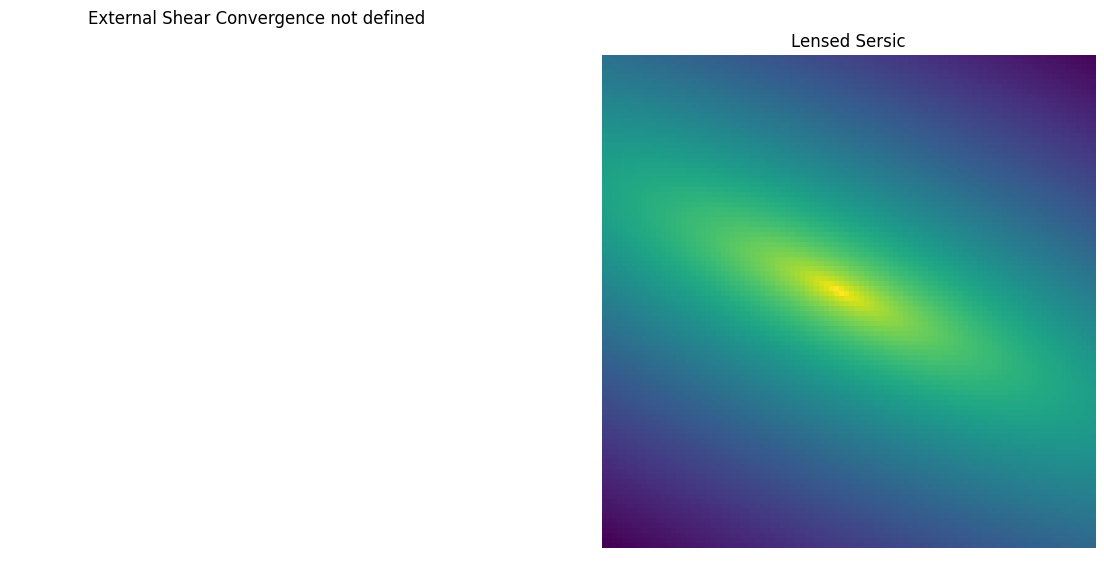

In [10]:
lens = caustic.lenses.ExternalShear(
    cosmology = cosmology,
    name = "externalshear",
    x0 = torch.tensor(0.),
    y0 = torch.tensor(0.),
    gamma_1 = torch.tensor(1.),
    gamma_2 = torch.tensor(-1.),
)
sim = Zoo_Sim(lens)
fig, axarr = plt.subplots(1,2, figsize = (14,7)) 
#convergence = avg_pool2d(lens.convergence(thx, thy, z_s, z_l).squeeze()[None, None], upsample_factor).squeeze()
#axarr[0].imshow(np.log10(convergence.numpy()), origin = "lower")
axarr[0].axis("off")
axarr[0].set_title("External Shear Convergence not defined")
axarr[1].imshow(np.log10(sim([z_l]).numpy()), origin = "lower")
axarr[1].axis("off")
axarr[1].set_title("Lensed Sersic")
plt.show()

## Mass Sheet (MassSheet)

This is a simple case of an external shear field which represents an infinite constant surface density sheet.

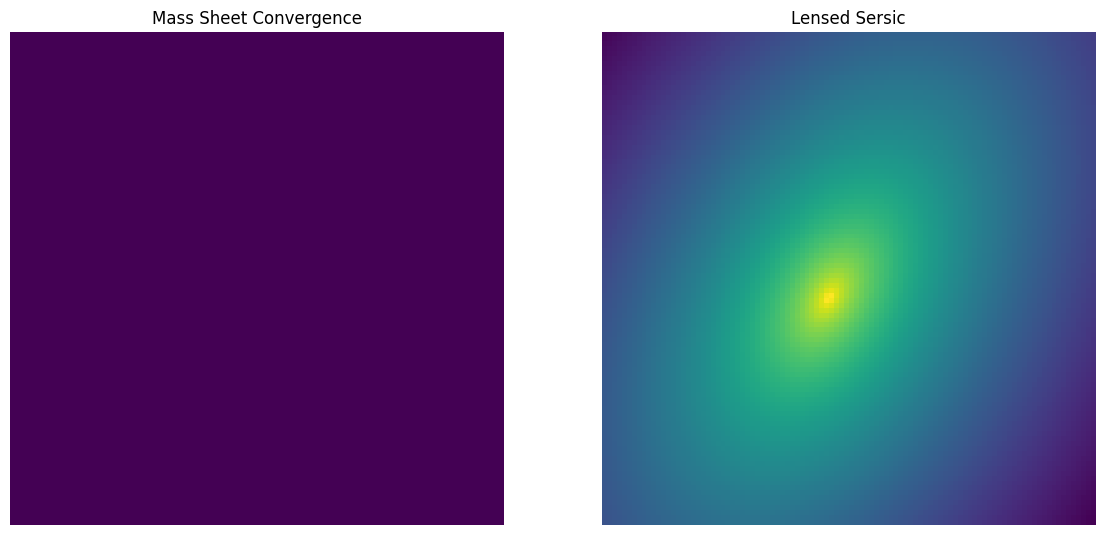

In [11]:
lens = caustic.lenses.MassSheet(
    cosmology = cosmology,
    name = "masssheet",
    x0 = torch.tensor(0.),
    y0 = torch.tensor(0.),
    surface_density = torch.tensor(1.5),
)
sim = Zoo_Sim(lens)
fig, axarr = plt.subplots(1,2, figsize = (14,7)) 
convergence = avg_pool2d(lens.convergence(thx, thy, z_s, z_l).squeeze()[None, None], upsample_factor).squeeze()
axarr[0].imshow(np.log10(convergence.numpy()), origin = "lower")
axarr[0].axis("off")
axarr[0].set_title("Mass Sheet Convergence")
axarr[1].imshow(np.log10(sim([z_l]).numpy()), origin = "lower")
axarr[1].axis("off")
axarr[1].set_title("Lensed Sersic")
plt.show()